# Light GBM

https://hackmd.io/@WangJengYun/HyLtemyxI
https://blog.csdn.net/weixin_41843918/article/details/89475621

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202304081540395.png" alt="0a747b1752ff4c7c9b368d7415b398c" style="zoom:40%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202304081540578.png" alt="a884b5b53ebd9665f526b82d74ca56b" style="zoom:40%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202304081550947.png" alt="1680940216389" style="zoom:40%;" />

### 1. Continuous variable binning

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_iris

d:\CODE\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
np.random.seed(11)

x1 = np.array([1.2, 2.9, 2.6, 3.3, 2.0, 2.5, 1.4, 2.1, 1.7, 3.0])
x2 = np.array([4.7, 5.5, 3.9, 6.2, 3.5, 4.5, 5.1, 2.7, 4.1, 3.8])
x3 = np.random.randint(0, 2, 10)
x4 = np.random.randint(0, 2, 10)
y = np.array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1])
data = pd.DataFrame({'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'y':y})
data

x1   x2  x3  x4  y
0  1.2  4.7   1   0  1
1  2.9  5.5   1   0  0
2  2.6  3.9   0   1  1
3  3.3  6.2   1   0  0
4  2.0  3.5   1   0  1
5  2.5  4.5   1   1  1
6  1.4  5.1   1   0  0
7  2.1  2.7   0   1  0
8  1.7  4.1   1   0  1
9  3.0  3.8   1   1  1

In [3]:
from sklearn.preprocessing import KBinsDiscretizer

# 将 x1 和 x2 分别进行等宽分箱，分成 2 个箱子
n_bins = 2
strategy = 'uniform'

kbins_x1 = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
kbins_x2 = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)

x1_binned = kbins_x1.fit_transform(data['x1'].values.reshape(-1, 1))
x2_binned = kbins_x2.fit_transform(data['x2'].values.reshape(-1, 1))

# 将分箱后的结果保存到原始数据集中
data['x1_binned'] = x1_binned
data['x2_binned'] = x2_binned

print(data)

    x1   x2  x3  x4  y  x1_binned  x2_binned
0  1.2  4.7   1   0  1        0.0        1.0
1  2.9  5.5   1   0  0        1.0        1.0
2  2.6  3.9   0   1  1        1.0        0.0
3  3.3  6.2   1   0  0        1.0        1.0
4  2.0  3.5   1   0  1        0.0        0.0
5  2.5  4.5   1   1  1        1.0        1.0
6  1.4  5.1   1   0  0        0.0        1.0
7  2.1  2.7   0   1  0        0.0        0.0
8  1.7  4.1   1   0  1        0.0        0.0
9  3.0  3.8   1   1  1        1.0        0.0


d:\CODE\Lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
d:\CODE\Lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


### 2. Exclusive Feature Bundling (EFB)

Dimensionality reduction is performed around these discrete features. LGBM adopts a dimensionality reduction method called Exclusive Feature Bundling (EFB)

- Simplified EFB calculation process
<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202303222002280.png" alt="0be767e9953d7db2a66752f524e6ba4" style="zoom:50%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202303222003609.png" alt="6a6d2ee962754f94b7232cb069835ce" style="zoom:50%;" />

#### 2.1 Basic principles of EFB algorithm

- conflict_rate 

This ratio is used to represent the proportion of conflicting values (i.e. non-mutually exclusive, taking non-zero values at the same time) in two features to measure the degree of mutual exclusion of the two features. Of course, the greater the conflict ratio, the lower the degree of mutual exclusion. For example, the following data set contains a total of four pieces of data, of which only the fourth piece of data obtains a non-zero value at the same time, so only one piece of data is conflicting, and the other data are mutually exclusive, so the conflict ratio is 1/4=0.25 :
|Feature1|Feature2|
|:--:|:--:|
|0|1|
|1|0|
|0|1|
|1|1|

And if the data set is as follows, the number of two features that are not 0 at the same time (non-all-zero samples) is 3, then the conflict ratio is 1/3:
|Sample situation|Feature 1|Feature 2|
|:--:|:--:|:--:|
|Non-all-zero samples|0|1|
|Non-all-zero samples|1|0|
|All zero samples|0|0|
|Non-all-zero samples|1|1|

LGBM provides a hyperparameter called max_conflict_rate, which is used to represent the maximum conflict ratio. When the conflict ratio of two features is less than the maximum conflict ratio (max_conflict_rate) we set, we consider that the two features do not conflict, but Mutually exclusive, can be bundled.

- Use Graph Coloring Problem to solve the problem of feature bundling process

LGBM converts the feature bundling problem into a **Graph Coloring Problem**. The graph coloring problem is a classic combinatorial optimization problem. The problem is described as: given an undirected graph, how to color each vertex in the graph with as few colors as possible so that adjacent vertices have different colors. During the EFB calculation process, different features will be regarded as points on the graph. If there is a conflict between the features, an undirected edge will be used to connect them. The weight of the edge is the conflict ratio. If the two features are mutually exclusive, Then there are no edges connecting each other. After the features and their conflicts are displayed in a graph, graph coloring can be further performed - that is, on the premise that adjacent points have different colors, use as few colors as possible to color the points on the graph. Since Conflicting features are connected by edges, so points of the same color are actually mutually exclusive features. Next, we only need to merge features of the same color.

#### 2.2 EFB calculation process

In [4]:
data

x1   x2  x3  x4  y  x1_binned  x2_binned
0  1.2  4.7   1   0  1        0.0        1.0
1  2.9  5.5   1   0  0        1.0        1.0
2  2.6  3.9   0   1  1        1.0        0.0
3  3.3  6.2   1   0  0        1.0        1.0
4  2.0  3.5   1   0  1        0.0        0.0
5  2.5  4.5   1   1  1        1.0        1.0
6  1.4  5.1   1   0  0        0.0        1.0
7  2.1  2.7   0   1  0        0.0        0.0
8  1.7  4.1   1   0  1        0.0        0.0
9  3.0  3.8   1   1  1        1.0        0.0

In [5]:
data[['x1_binned', 'x2_binned', 'x3', 'x4']]

x1_binned  x2_binned  x3  x4
0        0.0        1.0   1   0
1        1.0        1.0   1   0
2        1.0        0.0   0   1
3        1.0        1.0   1   0
4        0.0        0.0   1   0
5        1.0        1.0   1   1
6        0.0        1.0   1   0
7        0.0        0.0   0   1
8        0.0        0.0   1   0
9        1.0        0.0   1   1

In [6]:
def conflict_ratio_matrix(data):
    """
    冲突比例计算函数
    
    :param data: 计算冲突比例的dataframe
    :return:冲突比例矩阵
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    num_features = data.shape[1]
    # 创建空特征比例矩阵
    conflict_matrix = np.zeros((num_features, num_features))

    # 两层循环挑选两个特征
    for i in range(num_features):
        for j in range(i+1, num_features):
            # 计算特征冲突特征总数
            conflict_count = np.sum((data[:, i] != 0) & (data[:, j] != 0))
            # 计算不为0的特征总数
            total_count = np.sum((data[:, i] != 0) | (data[:, j] != 0))
            # 计算冲突比例
            conflict_ratio = conflict_count / total_count
            conflict_matrix[i, j] = conflict_ratio
            conflict_matrix[j, i] = conflict_ratio

    return conflict_matrix

In [7]:
conflict_ratio_matrix(data[['x1_binned', 'x2_binned', 'x3', 'x4']])

array([[0.        , 0.42857143, 0.44444444, 0.5       ],
       [0.42857143, 0.        , 0.625     , 0.125     ],
       [0.44444444, 0.625     , 0.        , 0.2       ],
       [0.5       , 0.125     , 0.2       , 0.        ]])

In [8]:
data[['x1_binned', 'x2_binned', 'x3', 'x4']]

x1_binned  x2_binned  x3  x4
0        0.0        1.0   1   0
1        1.0        1.0   1   0
2        1.0        0.0   0   1
3        1.0        1.0   1   0
4        0.0        0.0   1   0
5        1.0        1.0   1   1
6        0.0        1.0   1   0
7        0.0        0.0   0   1
8        0.0        0.0   1   0
9        1.0        0.0   1   1

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202303231529895.png" alt="1679556539065" style="zoom:50%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202303231538803.png" alt="1679557086174" style="zoom:50%;" />

- Fearure bunding

In [9]:
data['x2_binned']

0    1.0
1    1.0
2    0.0
3    1.0
4    0.0
5    1.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: x2_binned, dtype: float64

In [10]:
arr = np.array(data['x4'])
arr[arr != 0] += 1
arr

array([0, 0, 2, 0, 0, 2, 0, 2, 0, 2])

In [11]:
data['x2_binned&x4'] = arr + data['x2_binned']
data

x1   x2  x3  x4  y  x1_binned  x2_binned  x2_binned&x4
0  1.2  4.7   1   0  1        0.0        1.0           1.0
1  2.9  5.5   1   0  0        1.0        1.0           1.0
2  2.6  3.9   0   1  1        1.0        0.0           2.0
3  3.3  6.2   1   0  0        1.0        1.0           1.0
4  2.0  3.5   1   0  1        0.0        0.0           0.0
5  2.5  4.5   1   1  1        1.0        1.0           3.0
6  1.4  5.1   1   0  0        0.0        1.0           1.0
7  2.1  2.7   0   1  0        0.0        0.0           2.0
8  1.7  4.1   1   0  1        0.0        0.0           0.0
9  3.0  3.8   1   1  1        1.0        0.0           2.0

In [12]:
data[['x1_binned', 'x2_binned&x4', 'x3']]

x1_binned  x2_binned&x4  x3
0        0.0           1.0   1
1        1.0           1.0   1
2        1.0           2.0   0
3        1.0           1.0   1
4        0.0           0.0   1
5        1.0           3.0   1
6        0.0           1.0   1
7        0.0           2.0   0
8        0.0           0.0   1
9        1.0           2.0   1

### 3. Gradient-based One-Side Sampling (GOSS)

During the optimization algorithm process, each sample has a corresponding gradient calculation result. If the absolute value of the gradient of a certain sample is small, it means that the sample has been correctly classified or the predicted result is very close to the real result. In the subsequent parameters During the update process, these samples with small absolute gradient values contribute less to the improvement of parameters. Therefore, calculating the gradients of these small gradient samples again during each iterative calculation will cause a waste of resources to a certain extent. On the other hand, those samples with larger absolute gradient values have higher errors and therefore contribute more to model training. Therefore, the idea of GOSS is to sort all samples in descending order according to the absolute value of the gradient, and then extract the top $a\%$ samples with the largest absolute gradient value, and then regard other samples as small gradient samples, and start from these small gradient samples. Randomly select $b\%$ samples. Only sample small gradient samples (on one side) and retain all large gradient samples (on the other side).

&emsp;&emsp;The following points need to be noted when implementing GOSS:

- 1. The GOSS calculation process is to divide and sample samples based on the absolute value of the gradient, which is not the true value of the sample gradient;

- 2. The sample selection ratio in GOSS, that is, the top $a\%$ with the largest absolute gradient value and the randomly sampled $b\%$ in the small sample, are actually hyperparameters and can be flexibly adjusted during the modeling process. . The $a\%$ here can be replaced by a more professional hyperparameter name: top_rate, while the more professional name of $b\%$ extracted from the small sample is other_rate;

- 3. We know that the sample gradient is calculated based on the prediction result (specifically, the first derivative of the loss function), and we need to perform GOSS sampling before the first tree is built, and there is no model prediction result at this time. , the gradient calculation is based on the initial prediction value of LGBM. Similar to other ensemble learning, the initial prediction value of LGBM is also calculated based on different types of loss functions;

- 4. Since the model parameters will be updated in each iteration, resampling will be performed before each tree building. Unless the iteration process is artificially controlled (for example, using a very special Booster API, which will be introduced in detail later), generally speaking, top_rate Once set with other_rate, it will not change;

- 5. Regarding the numerical settings of top_rate and other_rate, generally speaking, the larger the top_rate and the smaller the other_rate, the greater the risk of model overfitting. Otherwise, the model learning ability will be limited. If these two parameters are large at the same time, It will increase the complexity of model training and increase the model training time. Regarding this set of parameters, there is no universally applicable value, and hyperparameter optimization still needs to be performed based on the actual situation.

- 6. Although the data brought into training is GOSS sampled data, during the subsequent growth of the decision tree, the gradient of the small gradient sample (and the second derivative of the loss function) will be multiplied by an expansion coefficient greater than 1. , and then added to the gradient of the large gradient sample (and the second derivative of the loss function) to form the gradient of a data set (and the second derivative of the loss function) to guide subsequent iterations. The reason why small gradient samples are further expanded and then added to the sample data gradient is to restore the original real data set gradient as much as possible. In other words, GOSS sampling does not want to change the gradient of the data set, but hopes to restore the complete gradient of the original data set as much as possible through a smaller amount of calculation, so as to improve the accuracy of modeling. Its basic process can Represented by the following picture: <img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202303231809934.png" alt="5a9d29da9104eae4106ca796a7a493c" style="zoom:50%;" />Specific How to calculate the expansion coefficient is actually not complicated. It is $\frac{1-a}{b}$, or $\frac{1-top\_rate}{other\_rate}$. For example, when top_rate=0.1, other_rate=0.2, the small sample gradient expansion coefficient is: $\frac{1-top\_rate}{other\_rate}=\frac{1-0.1}{0.2}=4.5$. The final sample gradient = large sample gradient + small sample gradient * 4.5 is calculated.

#### 3.2 GOSS calculation process example

In [14]:
def binary_cross_entropy(y_true, y_pred):
    """
    计算二分类交叉熵损失函数
    :param y_true: 真实标签，一个 Numpy 数组，形状为 (n_samples,)
    :param y_pred: 预测标签，一个 Numpy 数组，形状为 (n_samples,)
    :return:二分类交叉熵损失值，一个标量
    """
    # 确保输入的标签为 0 或 1
    y_true = np.clip(y_true, 1e-7, 1-1e-7)
    y_pred = np.clip(y_pred, 1e-7, 1-1e-7)
    # 计算二分类交叉熵损失
    loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()
    return loss

In [13]:
def binary_cross_entropy_grad(y_true, y_pred):
    """
    计算二分类交叉熵损失函数的一阶导数
    :param y_true: 真实标签，一个 Numpy 数组，形状为 (n_samples,)
    :param y_pred: 预测标签，一个 Numpy 数组，形状为 (n_samples,)
    :return:二分类交叉熵损失函数的一阶导数，一个 Numpy 数组，形状为 (n_samples,)
    """
    # 确保输入的标签为 0 或 1
    y_true = np.clip(y_true, 1e-7, 1-1e-7)
    y_pred = np.clip(y_pred, 1e-7, 1-1e-7)
    # 计算二分类交叉熵损失函数的一阶导数
    grad = (1 - y_true) / (1 - y_pred) - y_true / y_pred
    return grad

In [15]:
def binary_cross_entropy_hess(y_true, y_pred):
    """
    计算二分类交叉熵损失函数的二阶导数
    :param y_true: 真实标签，一个 Numpy 数组，形状为 (n_samples,)
    :param y_pred: 预测标签，一个 Numpy 数组，形状为 (n_samples,)
    :return: 生成的特征张和标签张量：二分类交叉熵损失函数的二阶导数，一个 Numpy 数组，形状为 (n_samples,)
    """
    # 确保输入的标签为 0 或 1
    y_true = np.clip(y_true, 1e-7, 1 - 1e-7)
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    # 计算二分类交叉熵损失函数的二阶导数
    hess = y_true / (y_pred ** 2) + (1 - y_true) / ((1 - y_pred) ** 2)
    return hess

In [16]:
data

x1   x2  x3  x4  y  x1_binned  x2_binned  x2_binned&x4
0  1.2  4.7   1   0  1        0.0        1.0           1.0
1  2.9  5.5   1   0  0        1.0        1.0           1.0
2  2.6  3.9   0   1  1        1.0        0.0           2.0
3  3.3  6.2   1   0  0        1.0        1.0           1.0
4  2.0  3.5   1   0  1        0.0        0.0           0.0
5  2.5  4.5   1   1  1        1.0        1.0           3.0
6  1.4  5.1   1   0  0        0.0        1.0           1.0
7  2.1  2.7   0   1  0        0.0        0.0           2.0
8  1.7  4.1   1   0  1        0.0        0.0           0.0
9  3.0  3.8   1   1  1        1.0        0.0           2.0

In [17]:
# 计算每个类别的频率
class_freq = data['y'].value_counts(normalize=True)

# 计算初始预测值
initial_prediction = np.log(class_freq[1] / class_freq[0])

print("初始预测值：", initial_prediction)

初始预测值： 0.4054651081081642


In [18]:
class_freq

y
1    0.6
0    0.4
Name: proportion, dtype: float64

In [19]:
class_freq[1]

0.6

In [20]:
y_pred = np.array([0.4054]*10)
y_pred

array([0.4054, 0.4054, 0.4054, 0.4054, 0.4054, 0.4054, 0.4054, 0.4054,
       0.4054, 0.4054])

In [21]:
data['y_pred'] = y_pred
data

x1   x2  x3  x4  y  x1_binned  x2_binned  x2_binned&x4  y_pred
0  1.2  4.7   1   0  1        0.0        1.0           1.0  0.4054
1  2.9  5.5   1   0  0        1.0        1.0           1.0  0.4054
2  2.6  3.9   0   1  1        1.0        0.0           2.0  0.4054
3  3.3  6.2   1   0  0        1.0        1.0           1.0  0.4054
4  2.0  3.5   1   0  1        0.0        0.0           0.0  0.4054
5  2.5  4.5   1   1  1        1.0        1.0           3.0  0.4054
6  1.4  5.1   1   0  0        0.0        1.0           1.0  0.4054
7  2.1  2.7   0   1  0        0.0        0.0           2.0  0.4054
8  1.7  4.1   1   0  1        0.0        0.0           0.0  0.4054
9  3.0  3.8   1   1  1        1.0        0.0           2.0  0.4054

In [22]:
#Sample gradient and hess value calculation
binary_cross_entropy_grad(data['y'], data['y_pred'])

0   -2.466699
1    1.681802
2   -2.466699
3    1.681802
4   -2.466699
5   -2.466699
6    1.681802
7    1.681802
8   -2.466699
9   -2.466699
dtype: float64

In [23]:
data['grad'] = binary_cross_entropy_grad(data['y'], data['y_pred'])
data

x1   x2  x3  x4  y  x1_binned  x2_binned  x2_binned&x4  y_pred      grad
0  1.2  4.7   1   0  1        0.0        1.0           1.0  0.4054 -2.466699
1  2.9  5.5   1   0  0        1.0        1.0           1.0  0.4054  1.681802
2  2.6  3.9   0   1  1        1.0        0.0           2.0  0.4054 -2.466699
3  3.3  6.2   1   0  0        1.0        1.0           1.0  0.4054  1.681802
4  2.0  3.5   1   0  1        0.0        0.0           0.0  0.4054 -2.466699
5  2.5  4.5   1   1  1        1.0        1.0           3.0  0.4054 -2.466699
6  1.4  5.1   1   0  0        0.0        1.0           1.0  0.4054  1.681802
7  2.1  2.7   0   1  0        0.0        0.0           2.0  0.4054  1.681802
8  1.7  4.1   1   0  1        0.0        0.0           0.0  0.4054 -2.466699
9  3.0  3.8   1   1  1        1.0        0.0           2.0  0.4054 -2.466699

In [24]:
# Calculate the hess value of the sample
binary_cross_entropy_hess(data['y'], data['y_pred'])

0    6.084606
1    2.828461
2    6.084606
3    2.828461
4    6.084606
5    6.084606
6    2.828461
7    2.828461
8    6.084606
9    6.084606
dtype: float64

In [25]:
data['hess'] = binary_cross_entropy_hess(data['y'], data['y_pred'])
data

x1   x2  x3  x4  y  x1_binned  x2_binned  x2_binned&x4  y_pred      grad  \
0  1.2  4.7   1   0  1        0.0        1.0           1.0  0.4054 -2.466699   
1  2.9  5.5   1   0  0        1.0        1.0           1.0  0.4054  1.681802   
2  2.6  3.9   0   1  1        1.0        0.0           2.0  0.4054 -2.466699   
3  3.3  6.2   1   0  0        1.0        1.0           1.0  0.4054  1.681802   
4  2.0  3.5   1   0  1        0.0        0.0           0.0  0.4054 -2.466699   
5  2.5  4.5   1   1  1        1.0        1.0           3.0  0.4054 -2.466699   
6  1.4  5.1   1   0  0        0.0        1.0           1.0  0.4054  1.681802   
7  2.1  2.7   0   1  0        0.0        0.0           2.0  0.4054  1.681802   
8  1.7  4.1   1   0  1        0.0        0.0           0.0  0.4054 -2.466699   
9  3.0  3.8   1   1  1        1.0        0.0           2.0  0.4054 -2.466699   

       hess  
0  6.084606  
1  2.828461  
2  6.084606  
3  2.828461  
4  6.084606  
5  6.084606  
6  2.828461  
7  2.828461  
8  6.084606  
9  6.084606

In [26]:
#GOSS sampling
abs_gradients = np.abs(data['grad'])
abs_gradients

0    2.466699
1    1.681802
2    2.466699
3    1.681802
4    2.466699
5    2.466699
6    1.681802
7    1.681802
8    2.466699
9    2.466699
Name: grad, dtype: float64

In [27]:
#order by ascending
sorted_index = np.argsort(-abs_gradients)
sorted_index

0    0
1    2
2    4
3    5
4    8
5    9
6    1
7    3
8    6
9    7
Name: grad, dtype: int64

In [28]:
#top_rate=0.2，other_rate=0.5
topn_index = sorted_index[:2]
topn_index.values

array([0, 2], dtype=int64)

In [29]:
topn_data = data.iloc[topn_index.values, :]
topn_data

x1   x2  x3  x4  y  x1_binned  x2_binned  x2_binned&x4  y_pred      grad  \
0  1.2  4.7   1   0  1        0.0        1.0           1.0  0.4054 -2.466699   
2  2.6  3.9   0   1  1        1.0        0.0           2.0  0.4054 -2.466699   

       hess  
0  6.084606  
2  6.084606

In [30]:
sorted_index[2:]

2    4
3    5
4    8
5    9
6    1
7    3
8    6
9    7
Name: grad, dtype: int64

In [31]:
raten_index = np.random.choice(sorted_index[2:].values, size=4, replace=False)
raten_index

array([4, 9, 3, 6], dtype=int64)

In [32]:
raten_data = data.iloc[raten_index, :]
raten_data

x1   x2  x3  x4  y  x1_binned  x2_binned  x2_binned&x4  y_pred      grad  \
4  2.0  3.5   1   0  1        0.0        0.0           0.0  0.4054 -2.466699   
9  3.0  3.8   1   1  1        1.0        0.0           2.0  0.4054 -2.466699   
3  3.3  6.2   1   0  0        1.0        1.0           1.0  0.4054  1.681802   
6  1.4  5.1   1   0  0        0.0        1.0           1.0  0.4054  1.681802   

       hess  
4  6.084606  
9  6.084606  
3  2.828461  
6  2.828461

### 4. hyperparameters of LGBMClassifier

In [ ]:
import lightgbm as lgb

In [33]:
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])

In [34]:
data.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [35]:
data.shape

(150, 5)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("target", axis=1), data["target"], test_size=0.2)

In [37]:
X_train.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
60                 5.0               2.0                3.5               1.0
87                 6.3               2.3                4.4               1.3
134                6.1               2.6                5.6               1.4
9                  4.9               3.1                1.5               0.1
51                 6.4               3.2                4.5               1.5

In [38]:
y_train

60     1.0
87     1.0
134    2.0
9      0.0
51     1.0
      ... 
70     1.0
67     1.0
145    2.0
91     1.0
81     1.0
Name: target, Length: 120, dtype: float64

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification

|Name|Description|      
|:--:|:--:| 
|num_leaves|一棵树上的叶子节点数，默认为 31| 
|max_depth|树的最大深度，默认值为 -1，表示无限制|
|min_split_gain|相当于min_impurity_decrease，再分裂所需最小增益。默认值为 0，表示无限制|
|min_child_weight|子节点的最小权重和。默认值为 1e-3。较大的 min_child_weight 可以防止过拟合| 
|min_child_samples|相当于min_samples_leaf，单个叶子节点上的最小样本数量。默认值为 20。较大的 min_child_samples 可以防止过拟合| 

- boosting_type: 使用的梯度提升算法类型，默认为 'gbdt'，可选项包括 'gbdt'（梯度提升决策树）、'dart'（Dropouts meet Multiple Additive Regression Trees）、'goss'（Gradient-based One-Side Sampling）和 'rf'（Random Forest，随机森林）。其中GBDT是最常用、且性能最稳定的 boosting 类型，也是boosting_type默认取值；而dart (Dropouts meet Multiple Additive Regression Trees)则是一种结合了 Dropout 和多重加性回归树的方法。它在每次迭代过程中随机选择一部分树进行更新，会较大程度增加模型随机性，可以用于存在较多噪声的数据集或者数据集相对简单（需要减少过拟合风险）的场景中；GOSS 是一种基于梯度的单侧采样方法。它在每次迭代中只使用具有较大梯度的样本进行训练，从而降低计算复杂度。goss(Gradient-based One-Side Sampling)则是前文介绍的梯度的单边采样算法，可以在保持较高精度的同时加速训练过程，适用于大规模数据集，可以在保持较高精度的同时加速训练过程，有些时候精度不如GBDT；而rf则是采用随机森林来进行“Boosting过程”，或者说此时就不再是Boosting，而是替换成了Bagging过程，类似于XGBRFClassifier的计算过程，此时LGBM本质上将按照RF的计算范式进行计算。

- subsample_for_bin：该参数表示对连续变量进行分箱时（直方图优化过程）抽取样本的个数，默认取值为200000，当实际抽样个数大于输入训练数据样本数量时，会带入全部样本进行计算。而如果boosting_type选择的是goss，则在直方图优化时会自动完成抽样，具体抽样策略是：会保留所有较小梯度的样本（即那些已经被模型很好拟合的样本），并对较大梯度的样本进行采样。这种策略能够在加速训练（大梯度样本的贡献）的同时有效防止过拟合（小梯度样本的贡献）。因此，如果boosting_type选择的是 "goss"，。则subsample_for_bin参数会失去作用，此时无论subsample_for_bin取值多少都不影响最终结果。

|Name|Description|      
|:--:|:--:| 
|learning_rate|学习率，即每次迭代中梯度提升的步长，默认值为 0.1| 
|n_estimators|迭代次数，即生成的基学习器的数量，默认值为 100|
|reg_alpha| L1 正则化系数，默认值为 0|
|reg_lambda| L2 正则化系数。默认值为 0|

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, 

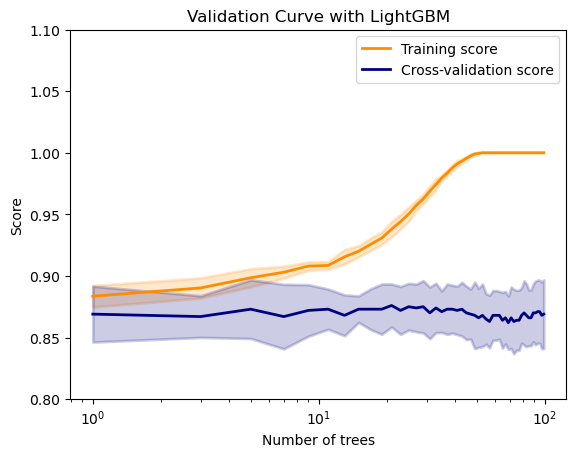

In [41]:
#force_col_wise=true
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, 
                           n_redundant=10)

model = LGBMClassifier()

param_range = np.arange(1, 100, 2)

train_scores, validation_scores = validation_curve(
    model, X, y, param_name="n_estimators", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.figure()
plt.title("Validation Curve with LightGBM")
plt.xlabel("Number of trees")
plt.ylabel("Score")
plt.ylim(0.8, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, validation_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

def plot_validation_curve(model, param_name, param_range, X, y, cv=5, scoring="accuracy", n_jobs=1):
    train_scores, validation_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure()
    plt.title(f"Validation Curve with {model.__class__.__name__}")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.8, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, validation_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[Li

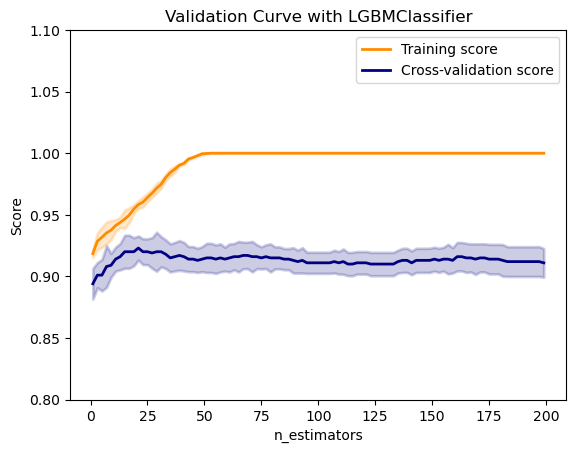

In [43]:
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, 
                           n_redundant=10, random_state=42)

model = LGBMClassifier()

param_range = np.arange(1, 200, 2)

plot_validation_curve(model, "n_estimators", param_range, X, y)

In [44]:
np.linspace(0.01, 0.5, 100)

array([0.01      , 0.01494949, 0.01989899, 0.02484848, 0.02979798,
       0.03474747, 0.03969697, 0.04464646, 0.04959596, 0.05454545,
       0.05949495, 0.06444444, 0.06939394, 0.07434343, 0.07929293,
       0.08424242, 0.08919192, 0.09414141, 0.09909091, 0.1040404 ,
       0.1089899 , 0.11393939, 0.11888889, 0.12383838, 0.12878788,
       0.13373737, 0.13868687, 0.14363636, 0.14858586, 0.15353535,
       0.15848485, 0.16343434, 0.16838384, 0.17333333, 0.17828283,
       0.18323232, 0.18818182, 0.19313131, 0.19808081, 0.2030303 ,
       0.2079798 , 0.21292929, 0.21787879, 0.22282828, 0.22777778,
       0.23272727, 0.23767677, 0.24262626, 0.24757576, 0.25252525,
       0.25747475, 0.26242424, 0.26737374, 0.27232323, 0.27727273,
       0.28222222, 0.28717172, 0.29212121, 0.29707071, 0.3020202 ,
       0.3069697 , 0.31191919, 0.31686869, 0.32181818, 0.32676768,
       0.33171717, 0.33666667, 0.34161616, 0.34656566, 0.35151515,
       0.35646465, 0.36141414, 0.36636364, 0.37131313, 0.37626

[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

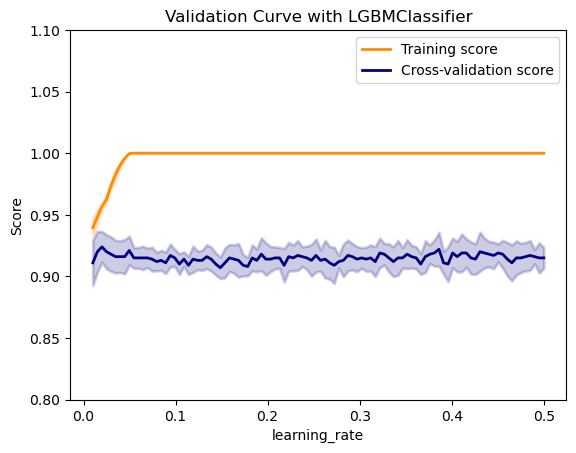

In [45]:
model = LGBMClassifier()

param_range = np.linspace(0.01, 0.5, 100)

#
plot_validation_curve(model, "learning_rate", param_range, X, y)

[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [Warning] No 

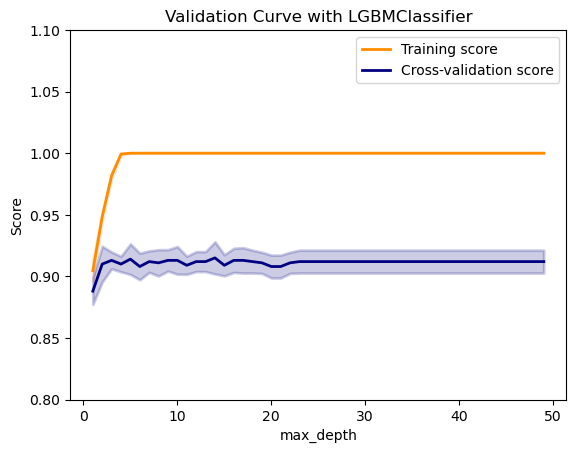

In [46]:
model = LGBMClassifier()

param_range = np.arange(1, 50, 1)

#max_depth
plot_validation_curve(model, "max_depth", param_range, X, y)

[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGB

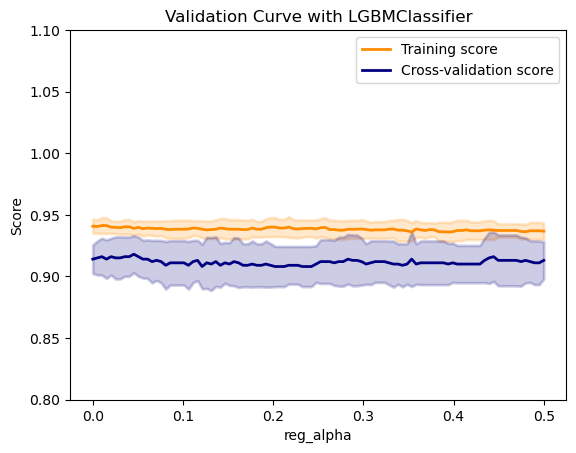

In [47]:
model = LGBMClassifier(n_estimators=10)

param_range = np.linspace(0.00, 0.5, 100)

#l1 regulization
plot_validation_curve(model, "reg_alpha", param_range, X, y)

[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGB

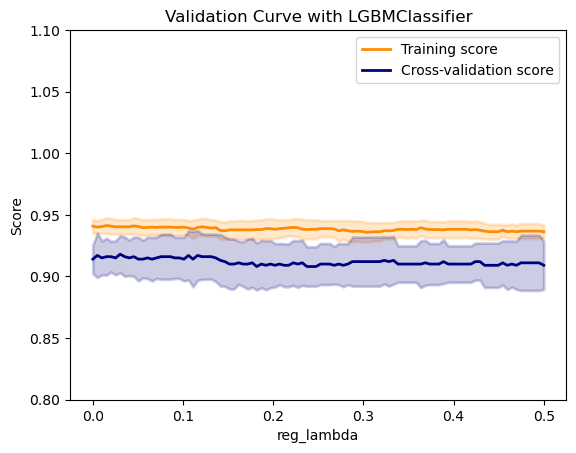

In [48]:
model = LGBMClassifier(n_estimators=10)

param_range = np.linspace(0.00, 0.5, 100)

#l2 regulization
plot_validation_curve(model, "reg_lambda", param_range, X, y)

#### Features and data processing class hyperparameters of LGBMClassifier

|Name|Description|      
|:--:|:--:| 
|subsample|模型训练时抽取的样本数量，取值范围为 (0, 1]，表示抽样比例，默认为1.0| 
|subsample_freq|抽样频率，表示每隔几轮进行一次抽样，默认取值为0，表示不进行随机抽样|
|colsample_bytree|在每次迭代（树的构建）时，随机选择特征的比例，取值范围为 (0, 1]，默认为1.0|

- subsample和subsample_for_bin之间的关系        
&emsp;&emsp;这两个参数尽管从字面理解都是抽样比例，但实际上这两个参数是完全独立的，彼此之间并不影响。其中subsample_for_bin抽样结果用于直方图构建，而subsample抽样结果则是用于模型训练，这两个抽样过程彼此独立，互不影响；
- subsample和subsample_freq之间的关系        
&emsp;&emsp;更加关键的是subsample_freq参数，如果subsample_freq=0，则无论subsample取值为多少，模型训练时都不会进行随机抽样；换而言之，只有subsample_freq不等于0，且subsample不等于1.0时，才会进行抽样；
- subsample_freq和colsample_bytree之间的关系        
&emsp;&emsp;不同于subsample是样本抽样，colsample_bytree是每次迭代（每次构建一颗树时）进行的特征抽样，并且colsample_bytree不受subsample_freq影响，即无论subsample_freq取值为多少，每次建树时都会根据colsample_bytree设置的比例进行列抽样。

#### Other hyperparameters of LGBMClassifier

|Name|Description|      
|:--:|:--:| 
|objective|指定目标函数，默认为None，会自动判断是二分类还是多分类问题，这里我们也可以手动设置 'binary'(用于二分类问题)或'multiclass'(用于多分类问题)| 
|class_weight|样本权重设置参数|
|importance_type|特征重要性计算方式，默认为 'split'，表示使用特征在模型中被选中作为分裂特征的次数，可选 'gain'，表示使用特征在模型中的分裂收益之和作为重要性评估指标|
|random_state|随机数种子|
|n_jobs|并行的线程数，默认为-1，调用全部可用线程|
|silent|是否沉默（不输出日志），默认为'warn'，仅显示警告和报错，可选'info'，用于打印全部信息|

#### LGBMRegressor loss function

- 均方误差（MSE, Mean Squared Error）：最常用的的损失函数，此时objective='regression' 或 objective='regression_l2'；
- 平均绝对误差（MAE, Mean Absolute Error）：通常用于标签存在异常值情况，此时objective='regression_l1'；
- Huber损失（Huber Loss）：适用于目标值存在大量异常值或者噪声时。Huber损失在预测误差较小时表现为均方误差，在预测误差较大时表现为平均绝对误差，这使得它对异常值具有更好的鲁棒性。此时objective='quantile'；
- Quantile损失（Quantile Loss）：用于分位数回归，最小化预测值与真实值之间的分位数损失，适用于需要对预测分布进行精细控制的场景（例如围绕某种分布进行预测）。此时objective='quantile'；
- Poisson损失（Poisson Loss）： 适用于计数问题，即目标值是非负整数且服从泊松分布。此时objective='poisson'
- Gamma损失（Gamma Loss）：适用于预测非负实数且服从伽马分布的目标值。此时objective='gamma'
- Tweedie损失（Tweedie Loss）：适用于广义线性模型（Generalized Linear Models, GLMs）中的 Tweedie 分布（非对称分布）的数据集。此时objective='tweedie'。

> Under normal circumstances, we choose between mean square error (MSE), mean absolute error (MAE) and Huber loss. MSE is usually preferred. When there is noise or outliers in the label, MAE will show better general performance. ization ability. And due to the special calculation process of MAE, its accuracy is not as good as MSE under normal data sets. Huber is a combination of the two and is suitable for data sets with a small number of outliers in labels. Huber is more robust to outliers while retaining good accuracy.

### 5.LightGBM hyperparameter optimization

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import time

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin

import inspect, re

from tqdm import tqdm
import gc
import lightgbm as lgb

In [ ]:
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
 
# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

# 连续字段转化
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

# 缺失值填补
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

# 标签值手动转化 
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [ ]:
features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

In [ ]:
train, test = train_test_split(tcc, random_state=22)

X_train = train.drop(columns=[ID_col, target]).copy()
X_test = test.drop(columns=[ID_col, target]).copy()

y_train = train['Churn'].copy()
y_test = test['Churn'].copy()

X_train_seq = pd.DataFrame()
X_test_seq = pd.DataFrame()

X_train_seq['tenure_year'] = ((72 - X_train['tenure']) // 12) + 2014
X_test_seq['tenure_year'] = ((72 - X_test['tenure']) // 12) + 2014

# 月份衍生
X_train_seq['tenure_month'] = (72 - X_train['tenure']) % 12 + 1
X_test_seq['tenure_month'] = (72 - X_test['tenure']) % 12 + 1

# 季度衍生
X_train_seq['tenure_quarter'] = ((X_train_seq['tenure_month']-1) // 3) + 1
X_test_seq['tenure_quarter'] = ((X_test_seq['tenure_month']-1) // 3) + 1

# 独热编码
enc = preprocessing.OneHotEncoder()
enc.fit(X_train_seq)

seq_new = list(X_train_seq.columns)

# 创建带有列名称的独热编码之后的df
X_train_seq = pd.DataFrame(enc.transform(X_train_seq).toarray(), 
                           columns = cate_colName(enc, seq_new, drop=None))

X_test_seq = pd.DataFrame(enc.transform(X_test_seq).toarray(), 
                          columns = cate_colName(enc, seq_new, drop=None))

# 调整index
X_train_seq.index = X_train.index
X_test_seq.index = X_test.index

In [ ]:
ord_enc = OrdinalEncoder()
ord_enc.fit(X_train[category_cols])

X_train_OE = pd.DataFrame(ord_enc.transform(X_train[category_cols]), columns=category_cols)
X_train_OE.index = X_train.index
X_train_OE = pd.concat([X_train_OE, X_train[numeric_cols]], axis=1)

X_test_OE = pd.DataFrame(ord_enc.transform(X_test[category_cols]), columns=category_cols)
X_test_OE.index = X_test.index
X_test_OE = pd.concat([X_test_OE, X_test[numeric_cols]], axis=1)

In [ ]:
X_train_OE = X_train_OE.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test_OE = X_test_OE.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
X_train_OE

In [ ]:
X_test_OE

In [ ]:
y_train

In [ ]:
gbm = lgb.LGBMClassifier()
gbm

In [ ]:
gbm.fit(X_train_OE, y_train)

In [ ]:
gbm.predict(X_test_OE)

In [ ]:
gbm.score(X_train_OE, y_train)

In [ ]:
gbm.score(X_test_OE, y_test)

|Name|Description|      
|:--:|:--:| 
|num_leaves|一棵树上的叶子节点数，默认为 31| 
|max_depth|树的最大深度，默认值为 -1，表示无限制|
|min_split_gain|相当于min_impurity_decrease，再分裂所需最小增益。默认值为 0，表示无限制|
|min_child_weight|子节点的最小权重和。默认值为 1e-3。较大的 min_child_weight 可以防止过拟合| 
|min_child_samples|相当于min_samples_leaf，单个叶子节点上的最小样本数量。默认值为 20。较大的 min_child_samples 可以防止过拟合| 
|boosting_type| 使用的梯度提升算法类型，默认为GBDT|
|subsample_for_bin|该参数表示对连续变量进行分箱时（直方图优化过程）抽取样本的个数，默认取值为200000|
|learning_rate|学习率，即每次迭代中梯度提升的步长，默认值为 0.1| 
|n_estimators|迭代次数，即生成的基学习器的数量，默认值为 100|
|reg_alpha| L1 正则化系数，默认值为 0|
|reg_lambda| L2 正则化系数。默认值为 0|
|subsample|模型训练时抽取的样本数量，取值范围为 (0, 1]，表示抽样比例，默认为1.0| 
|subsample_freq|抽样频率，表示每隔几轮进行一次抽样，默认取值为0，表示不进行随机抽样|
|colsample_bytree|在每次迭代（树的构建）时，随机选择特征的比例，取值范围为 (0, 1]，默认为1.0|

|params|经验最优范围|
|:--:|:--:|
|num_leaves|range(20, 51, 2)|
|max_depth|range(5, 15, 2))| 
|learning_rate|np.linspace(0.01, 0.2, 5)|
|n_estimators|range(10, 160, 70)|
|boosting_type|['gbdt', 'goss']|
|colsample_bytree|[0.6, 0.8, 1.0]|
|reg_alpha|np.linspace(0.01, 0.1, 2)|
|reg_lambda|np.linspace(0.01, 0.1, 2)|

#### HyperOPT based on bayesian optimazation

In [49]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

> **hp.quniform("参数名称", 下界, 上界, 步长)** - 适用于均匀分布的浮点数<br><br>
> **hp.uniform("参数名称",下界, 上界)** - 适用于随机分布的浮点数<br><br>
> **hp.randint("参数名称",上界)** - 适用于[0,上界)的整数，区间为前闭后开<br><br>
> **hp.choice("参数名称",["字符串1","字符串2",...])** - 适用于字符串类型，最优参数由索引表示<br><br>
> **hp.choice("参数名称",[\*range(下界，上界，步长)])** - 适用于整数型，最优参数由索引表示<br><br>
> **hp.choice("参数名称",[整数1,整数2,整数3,...])** - 适用于整数型，最优参数由索引表示<br><br>
> **hp.choice("参数名称",["字符串1",整数1,...])** - 适用于字符与整数混合，最优参数由索引表示

In [ ]:
LGBM_params_space = {'max_depth': hp.choice('max_depth', np.arange(10, 50).tolist()), 
                     'num_leaves': hp.choice('num_leaves', np.arange(10, 50).tolist()), 
                     'n_estimators': hp.choice('n_estimators', np.arange(10, 100).tolist()), 
                     'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss']), 
                     'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0), 
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.1), 
                     'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.5), 
                     'reg_lambda':  hp.uniform('reg_lambda', 0.01, 0.5)}

In [ ]:
def hyperopt_lgbm(params, train=True):
    max_depth = params['max_depth']
    num_leaves = params['num_leaves']
    n_estimators = params['n_estimators']
    boosting_type = params['boosting_type']
    colsample_bytree = params['colsample_bytree']
    learning_rate = params['learning_rate']
    reg_alpha = params['reg_alpha']        
    reg_lambda = params['reg_lambda']        
        
    lgbm = LGBMClassifier(random_state = 12, 
                          max_depth = max_depth, 
                          num_leaves = num_leaves, 
                          n_estimators = n_estimators, 
                          boosting_type = boosting_type, 
                          colsample_bytree = colsample_bytree, 
                          learning_rate = learning_rate, 
                          reg_alpha = reg_alpha, 
                          reg_lambda = reg_lambda)
    
    res = -cross_val_score(lgbm, X_train_OE, y_train).mean()

    return res

In [ ]:
def param_hyperopt_lgbm(max_evals):
    params_best = fmin(fn = hyperopt_lgbm,
                       space = LGBM_params_space,
                       algo = tpe.suggest,
                       max_evals = max_evals)    
    
    return params_best

In [ ]:
lgbm_params_best = param_hyperopt_lgbm(100)

In [ ]:
lgbm_params_best

In [ ]:
np.arange(10, 50).tolist()[15]

In [ ]:
lgbm = LGBMClassifier(random_state = 12, 
                      max_depth =  np.arange(10, 50).tolist()[15], 
                      num_leaves = np.arange(10, 50).tolist()[0], 
                      n_estimators = np.arange(10, 100).tolist()[72], 
                      boosting_type = ['gbdt', 'goss'][1], 
                      colsample_bytree = 0.3186487096763566, 
                      learning_rate = 0.04957639366091329, 
                      reg_alpha = 0.04712785043759807, 
                      reg_lambda = 0.21992628721582047).fit(X_train_OE, y_train)

In [ ]:
lgbm.score(X_train_OE, y_train), lgbm.score(X_test_OE, y_test)

#### GridSearch 

<center><img src="https://s2.loli.net/2022/05/01/R5gubzxKyrVeWcd.png" alt="image-20220501213631356" style="zoom:50%;" />

|params|经验最优范围|
|:--:|:--:|
|num_leaves|range(20, 51, 2)|
|max_depth|range(5, 15, 2))| 
|learning_rate|np.linspace(0.01, 0.2, 5)|
|n_estimators|range(10, 160, 70)|
|boosting_type|['gbdt', 'goss']|
|colsample_bytree|[0.6, 0.8, 1.0]|
|(第一阶段)reg_alpha|np.linspace(0.01, 0.1, 2)|
|(第二阶段)reg_lambda|np.linspace(0.01, 0.1, 2)|

In [ ]:
list(np.linspace(0.01, 0.2, 5))

- round 1

In [ ]:
start = time.time()

# 设置超参数空间
parameter_space = {
    "num_leaves": range(20, 51, 2), 
    "max_depth": range(5, 15, 2),
    "learning_rate": list(np.linspace(0.01, 0.2, 5)),
    "n_estimators": range(10, 160, 70), 
    "boosting_type":['gbdt', 'goss'], 
    "colsample_bytree":[0.6, 0.8, 1.0]}

# 实例化模型与评估器
LGBM_0 = LGBMClassifier(random_state=12)
grid_LGBM_0 = GridSearchCV(LGBM_0, parameter_space, n_jobs=15)

# 模型训练
grid_LGBM_0.fit(X_train_OE, y_train)

print(time.time()-start)

In [ ]:
grid_LGBM_0.best_score_

In [ ]:
grid_LGBM_0.score(X_train_OE, y_train), grid_LGBM_0.score(X_test_OE, y_test)

In [ ]:
grid_LGBM_0.best_params_

- round 2

In [ ]:
start = time.time()

# 设置超参数空间
parameter_space = {
    "num_leaves": range(30, 35), 
    "max_depth": range(10, 14),
    "learning_rate": list(np.linspace(0.01, 0.1, 5)),
    "n_estimators": range(70, 91, 5), 
    "boosting_type":['gbdt', 'goss'], 
    "colsample_bytree":[0.5, 0.6, 0.7]}

# 实例化模型与评估器
LGBM_1 = LGBMClassifier(random_state=12)
grid_LGBM_1 = GridSearchCV(LGBM_1, parameter_space, n_jobs=15)

# 模型训练
grid_LGBM_1.fit(X_train_OE, y_train)

print(time.time()-start)

In [ ]:
grid_LGBM_1.best_score_

In [ ]:
grid_LGBM_1.score(X_train_OE, y_train), grid_LGBM_1.score(X_test_OE, y_test)

In [ ]:
grid_LGBM_1.best_params_

- round 3

In [ ]:
start = time.time()

# 设置超参数空间
parameter_space = {
    "num_leaves": range(30, 35), 
    "max_depth": range(12, 17),
    "learning_rate": list(np.linspace(0.04, 0.07, 5)),
    "n_estimators": range(60, 81, 2), 
    "boosting_type":['gbdt', 'goss'], 
    "colsample_bytree":[0.55, 0.6, 0.65]}

# 实例化模型与评估器
LGBM_2 = LGBMClassifier(random_state=12)
grid_LGBM_2 = GridSearchCV(LGBM_2, parameter_space, n_jobs=15)

# 模型训练
grid_LGBM_2.fit(X_train_OE, y_train)

print(time.time()-start)

In [ ]:
grid_LGBM_2.best_score_

In [ ]:
grid_LGBM_2.score(X_train_OE, y_train), grid_LGBM_2.score(X_test_OE, y_test)

In [ ]:
grid_LGBM_2.best_params_

- round 3

In [ ]:
start = time.time()

# 设置超参数空间
parameter_space = {
    "num_leaves": range(32, 37), 
    "max_depth": range(14, 18),
    "learning_rate": list(np.linspace(0.05, 0.06, 5)),
    "n_estimators": range(65, 70), 
    "boosting_type":['gbdt', 'goss'], 
    "colsample_bytree":[0.59, 0.6, 0.61]}

# 实例化模型与评估器
LGBM_3 = LGBMClassifier(random_state=12)
grid_LGBM_3 = GridSearchCV(LGBM_3, parameter_space, n_jobs=15)

# 模型训练
grid_LGBM_3.fit(X_train_OE, y_train)

print(time.time()-start)

In [ ]:
grid_LGBM_3.best_score_

In [ ]:
grid_LGBM_3.score(X_train_OE, y_train), grid_LGBM_3.score(X_test_OE, y_test)

In [ ]:
grid_LGBM_3.best_params_

- round 5

In [ ]:
start = time.time()

# 设置超参数空间
parameter_space = {
    "num_leaves": range(32, 37), 
    "max_depth": range(14, 18),
    "learning_rate": list(np.linspace(0.05, 0.06, 5)),
    "n_estimators": range(65, 70), 
    "boosting_type":['gbdt', 'goss'], 
    "colsample_bytree":[0.585, 0.59, 0.595]}

# 实例化模型与评估器
LGBM_4 = LGBMClassifier(random_state=12)
grid_LGBM_4 = GridSearchCV(LGBM_4, parameter_space, n_jobs=15)

# 模型训练
grid_LGBM_4.fit(X_train_OE, y_train)

print(time.time()-start)

In [ ]:
grid_LGBM_4.best_score_

In [ ]:
grid_LGBM_4.score(X_train_OE, y_train), grid_LGBM_4.score(X_test_OE, y_test)

In [ ]:
grid_LGBM_4.best_params_

- final round 

In [ ]:
start = time.time()

# 设置超参数空间
parameter_space = {
    "num_leaves": range(32, 37), 
    "max_depth": range(14, 18),
    "learning_rate": list(np.linspace(0.05, 0.06, 5)),
    "n_estimators": range(65, 70), 
    "boosting_type":['gbdt', 'goss'], 
    "colsample_bytree":[0.585, 0.59, 0.595], 
    "reg_alpha":list(np.linspace(0.01, 0.1, 2))}

# 实例化模型与评估器
LGBM_5 = LGBMClassifier(random_state=12)
grid_LGBM_5 = GridSearchCV(LGBM_5, parameter_space, n_jobs=15)

# 模型训练
grid_LGBM_5.fit(X_train_OE, y_train)

print(time.time()-start)

In [ ]:
grid_LGBM_5.best_score_

In [ ]:
grid_LGBM_5.score(X_train_OE, y_train), grid_LGBM_5.score(X_test_OE, y_test)

In [ ]:
grid_LGBM_5.best_params_

Cross Validation

In [ ]:
kf = KFold(n_splits=5, random_state=12, shuffle=True)

In [ ]:
kf = KFold(n_splits=5, random_state=12, shuffle=True)

X_train_OE = X_train_OE.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
for train_part_index, eval_index in kf.split(X_train_OE, y_train):
    print(train_part_index)
    print(eval_index)
    break

In [ ]:
X_train_OE.loc[train_part_index]

In [ ]:
train_part_index_l = []
eval_index_l = []

for train_part_index, eval_index in kf.split(X_train_OE, y_train):
    train_part_index_l.append(train_part_index)
    eval_index_l.append(eval_index)

In [ ]:
test_predict = []
kf = KFold(n_splits=3, random_state=11, shuffle=True)

for train_part_index, eval_index in kf.split(X_train_OE, y_train):
    # 在训练集上训练
    X_train_part = X_train_OE.loc[train_part_index]
    y_train_part = y_train.loc[train_part_index]
    clf.fit(X_train_part, y_train_part)
    # 将测试集上预测结果填入predict数据集
    test_predict.append(clf.predict_proba(X_test_OE)[:, 1])

In [ ]:
np.array(test_predict).mean(0)

In [ ]:
res = (np.array(test_predict).mean(0) >= 0.5) * 1

In [ ]:
res

In [ ]:
y_test

In [ ]:
accuracy_score(res, y_test)

In [ ]:
#LGBM+grid
test_predict = []
kf = KFold(n_splits=3, random_state=11, shuffle=True)

for train_part_index, eval_index in kf.split(X_train_OE, y_train):
    # 在训练集上训练
    X_train_part = X_train_OE.loc[train_part_index]
    y_train_part = y_train.loc[train_part_index]
    grid_LGBM_5.best_estimator_.fit(X_train_part, y_train_part)
    # 将测试集上预测结果填入predict数据集
    test_predict.append(grid_LGBM_5.predict_proba(X_test_OE)[:, 1])